In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import datacube

import matplotlib.pyplot as plt
import matplotlib.cm as color_maps  
from matplotlib.pyplot import figure, cm

import json
import time
import sys
import os

import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import ogr, gdal

from datetime import datetime
#from time import time

import skimage
from skimage import exposure
from skimage import morphology
from skimage.morphology import disk
from skimage.morphology import rectangle
from skimage.filters import rank

import glob
import fiona
import subprocess

import utils.data_cube_utilities.dc_utilities as utils
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr, write_png_from_xr
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_mosaic
from utils.data_cube_utilities.dc_sar_utils import dn_to_db 

from rmmeh.vanilla import rmmeh

In [2]:
def rasterization(InputVector,OutputImage,RefImage):
    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    print(Image)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterising
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)


    print("Done.")

    print('finist_rasterise_vector')
    
def rgb(dataset, bands = ['nir', 'red', 'green'], paint_on_mask = []):
    
    fig=plt.figure()
    fig.set_size_inches(9, 9)
    
    rgb = np.stack([dataset[bands[0]], dataset[bands[1]], dataset[bands[2]]], axis = -1)
    rgb = rgb.astype(np.float32)

    p2, p98 = np.percentile(rgb, (2, 98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98)) * 255.0

    rgb = rgb.astype(int) 

    for mask, color in paint_on_mask:        
        rgb[mask] = np.array([256,256,256]) - np.array(color).astype(np.int16)
    plt.imshow(rgb)
        
def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
      
    clear_pixels = dataset.SCL.values == (2 ) 
    water_pixels = dataset.SCL.values == (4 )
    shadow_pixels= dataset.SCL.values == (3 )
           
    #a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    a_clean_mask = np.logical_or(1, 1)
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    #cloud_free_boolean_mask = generate_cloud_mask(dataset)
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

## 1. Initialization

In [3]:
sugarcane_shp = './shp/clipped_sugarcane.shp'
rice_shp = './shp/clipped_rice.shp'

'''
longitude_extents = (99.6910, 99.7517)
latitude_extents = (16.4781, 16.4355)
'''

longitude_extents = (99.77673, 99.79688)
latitude_extents = (16.53331, 16.51118)
                  
bands = ['coastal', 
         'blue', 'green', 'red', 
         #'veg5', 'veg6', 'veg7', 
         'nir', 'narrow_nir', 
         #'water_vapour', 'swir1', 'swir2', 
         'AOT', 'SCL']
         #'SCL', 'WVP', 'AOT', 'pixel_qa']

time_extents = ('2018-05-01', '2020-05-31')
#time_extents = ('2020-01-01', '2021-05-31')

n_sample = 10000
safety_factor = 1.5

result_file = ("x_train", "y_train")

## 2. Get sentinel2 data from ODC as the same size and resolution of input raster

In [4]:
start_time = time.time()
print("Mem status before loading dataset")
!cat /proc/meminfo | grep Mem

'''
dc = datacube.Datacube(app = 'my_app', config = '/home/ubuntu/.datacubeThailandS2.conf')

platform = "SENTINEL_2_Thailand"
product = "s2_level2a_Thailand"

s2_dataset = dc.load(latitude = latitude_extents,
                     longitude = longitude_extents,
                     #latitude = (latitude_extents[0], midpoint[0]),
                     #longitude = (longitude_extents[0], midpoint[1]),
                     platform = platform,
                     time = time_extents,
                     product = product,
                     measurements = bands)

'''



dc = datacube.Datacube()

s2_dataset = dc.load(
                        product = 'sentinel2_ingestion',
                        latitude = latitude_extents,
                        longitude = longitude_extents,
                        time = time_extents,
                        measurements = bands
                    )

loading_time = time.time() - start_time
print("loading time:", time.time() - start_time,"Sec.")

print("Mem status after dataset loaded")
!cat /proc/meminfo | grep Mem


Mem status before loading dataset
MemTotal:       66733816 kB
MemFree:        33430096 kB
MemAvailable:   37294424 kB


/opt/miniconda/envs/cubeenv/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


loading time: 128.44342827796936 Sec.
Mem status after dataset loaded
MemTotal:       66733816 kB
MemFree:        33082028 kB
MemAvailable:   36946576 kB


In [5]:
#s2_dataset.to_netcdf("odc_on_disk.nc")

s2_dataset

<xarray.Dataset>
Dimensions:      (latitude: 240, longitude: 218, time: 148)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-05T03:49:42.788000 ... 2020-05...
  * latitude     (latitude) float64 16.53 16.53 16.53 ... 16.51 16.51 16.51
  * longitude    (longitude) float64 99.78 99.78 99.78 99.78 ... 99.8 99.8 99.8
    spatial_ref  int32 4326
Data variables:
    coastal      (time, latitude, longitude) uint16 7292 7292 7250 ... 860 860
    blue         (time, latitude, longitude) uint16 6256 6244 6280 ... 909 953
    green        (time, latitude, longitude) uint16 5704 5680 5700 ... 1308 1316
    red          (time, latitude, longitude) uint16 5448 5412 5396 ... 1520 1552
    nir          (time, latitude, longitude) uint16 5604 5624 5668 ... 1642 1666
    narrow_nir   (time, latitude, longitude) uint16 5669 5669 5631 ... 1648 1648
    AOT          (time, latitude, longitude) uint16 201 201 201 ... 144 144 144
    SCL          (time, latitude, longitude) uint8 9 9 9 9 9 9 9 ... 7 7 7 7 8 8
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [6]:
#np.reshape(s2_dataset['blue'].values.shape)
#s2_dataset['time']

In [7]:
tmp_df = pd.DataFrame({'timestamp': s2_dataset['time'].values})
tmp_df['week_year'] = tmp_df['timestamp'].dt.strftime("%Y-%U")
tmp_df.week_year.nunique()

104

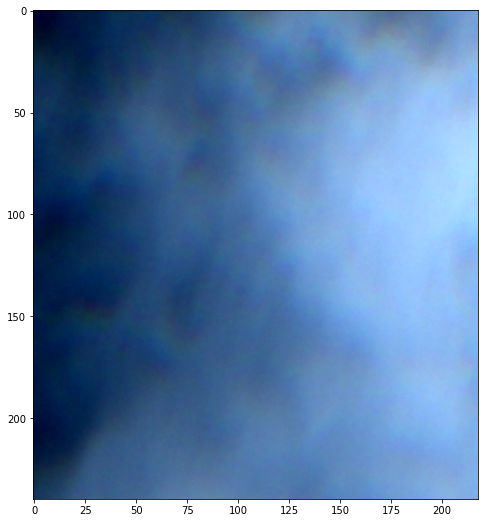

In [8]:
s2_mosaic=mrf_mosaic(s2_dataset)
s2_mosaic

#draw image
rgb(s2_mosaic, bands=['red','green','blue'])

#save mosaic to GeoTIFF and will be use as RefImage 
measurements = ['red', 'green', 'blue']
RefImage = './refImage_5.tif'
write_geotiff_from_xr(RefImage, s2_mosaic, measurements, no_data=0)

In [9]:
#Image area in sq.km.
1652*1317*(100)/(1000*1000)

217.5684

In [10]:
tmp_array = s2_dataset.red.values
tmp_array.shape

(148, 240, 218)

## 1. read shape file

In [11]:
def records(file):  
    # generator 
    reader = ogr.Open(file)
    layer = reader.GetLayer(0)
    result = []
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        polygon = json.loads(feature.ExportToJson())
        geojson = json.dumps(polygon['geometry'])
        tmp_polygon = ogr.CreateGeometryFromJson(geojson)
        result.append(tmp_polygon)
    return result
        
def in_polygon(lat, lon, shp_records):
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(lon, lat)

    for i, polygon in enumerate(shp_records):
        if point.Within(polygon):
            return True
        
    return False

In [12]:
sugarcane_area = records(sugarcane_shp)
rice_area = records(rice_shp)

In [13]:
#try in-polygon test
sugar_point = (16.4006, 99.7045)
rice_point = (16.3647, 99.6797)

print("is sugar_point in sugar_area", in_polygon(sugar_point[0], sugar_point[1], sugarcane_area))
print("is sugar_point in rice_area", in_polygon(sugar_point[0], sugar_point[1], rice_area))
print("is rice_point in sugar_area", in_polygon(rice_point[0], rice_point[1], sugarcane_area))
print("is rice_point in rice_area", in_polygon(rice_point[0], rice_point[1], rice_area))

is sugar_point in sugar_area True
is sugar_point in rice_area False
is rice_point in sugar_area False
is rice_point in rice_area True


### Create Raster

In [14]:
InputVector = sugarcane_shp
OutputImage = 'clipped_sugarcane5.tif'
rasterization(InputVector,OutputImage,RefImage)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7effcc834bd0> >
Rasterising shapefile...
Done.
finist_rasterise_vector


In [15]:
InputVector = rice_shp
OutputImage = 'clipped_rice5.tif'
rasterization(InputVector,OutputImage,RefImage)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f0000163360> >
Rasterising shapefile...
Done.
finist_rasterise_vector


## 3. Sampling locations from (1.)

In [16]:
print(len(s2_dataset.latitude.data), len(s2_dataset.longitude.data))

240 218


In [17]:
real_sugar = rasterio.open('clipped_sugarcane4.tif')
real_rice = rasterio.open('clipped_rice4.tif')
print(real_sugar.height, real_sugar.width)

sugar_pix = real_sugar.read(1)
rice_pix = real_rice.read(1)


350 446


In [18]:
import random

#list of (lat,lon)
sugarcane_points = []
rice_points = []
other_points = []


sugarcane_ji = []
rice_ji = []
other_ji = []

labels = []
#n_sample = 5
count = 0

print("start_sampling n=",(len(s2_dataset.latitude.data)*len(s2_dataset.longitude.data)))
print("area =", (len(s2_dataset.latitude.data)*len(s2_dataset.longitude.data))*100/1000000)
#while len(sugarcane_points) < n_sample*safety_factor or len(rice_points) < n_sample*safety_factor :
for j in range(len(s2_dataset.latitude.data)) : 
    for i in range(len(s2_dataset.longitude.data)) : 
        lat = s2_dataset.latitude.data[j]
        lon = s2_dataset.longitude.data[i]


        #if in_polygon(lat, lon, sugarcane_area):
        if rice_pix[j][i]==0 and sugar_pix[j][i]==1:
            #print(lat, lon)
            #print("sugar")
            sugarcane_points.append((lat,lon))
            sugarcane_ji.append((j,i))
            #label.append(1)
        #elif in_polygon(lat, lon, rice_area):
        
        #elif rice_pix[j][i]==1 and sugar_pix[j][i]==0:
        elif rice_pix[j][i]==1:
            #print(lat, lon)
            #print("rice")
            rice_points.append((lat,lon))
            rice_ji.append((j,i))
            #label.append(2)
            
        else: 
            other_points.append((lat,lon))
            other_ji.append((j,i))
            #label.append(0)
        count += 1
        
        if count<10 or count%10000 == 0:
            print("iteration:", count, "sugarcane_points:", len(sugarcane_points), "rice_points:", len(rice_points), "other_points:", len(other_points))


start_sampling n= 52320
area = 5.232
iteration: 1 sugarcane_points: 0 rice_points: 1 other_points: 0
iteration: 2 sugarcane_points: 0 rice_points: 2 other_points: 0
iteration: 3 sugarcane_points: 0 rice_points: 3 other_points: 0
iteration: 4 sugarcane_points: 0 rice_points: 4 other_points: 0
iteration: 5 sugarcane_points: 0 rice_points: 5 other_points: 0
iteration: 6 sugarcane_points: 0 rice_points: 6 other_points: 0
iteration: 7 sugarcane_points: 0 rice_points: 7 other_points: 0
iteration: 8 sugarcane_points: 0 rice_points: 8 other_points: 0
iteration: 9 sugarcane_points: 0 rice_points: 9 other_points: 0
iteration: 10000 sugarcane_points: 0 rice_points: 8302 other_points: 1698
iteration: 20000 sugarcane_points: 497 rice_points: 16854 other_points: 2649
iteration: 30000 sugarcane_points: 1746 rice_points: 21037 other_points: 7217
iteration: 40000 sugarcane_points: 3418 rice_points: 25127 other_points: 11455
iteration: 50000 sugarcane_points: 3765 rice_points: 33658 other_points: 12577


## 4. get NDVI value from (2) using locations from (3) 

 $$ {NDVI} = \frac{(X_{NIR}-X_{Red})}{(X_{NIR}+X_{Red})}$$


In [19]:
#s2_dataset['ndvi'] = tmp_ndvi
s2_dataset= s2_dataset.assign(ndvi=lambda x: (x.nir.astype(np.double)-x.red.astype(np.double))/(x.nir.astype(np.double)+x.red.astype(np.double)+.0001))
s2_dataset= s2_dataset.assign(ndwi=lambda x: (x.green.astype(np.double)-x.nir.astype(np.double))/(x.green.astype(np.double)+x.nir.astype(np.double)+.0001))


In [20]:
#filter only rows that has number of zero-value less than 10%

def filter_row(all_points, max_n_sample):
    week_year_array = None
    tmp_array = None
    location = None
    count = 0
    for (lat,lon) in all_points:
        count+=1
        
        if count % 1000==0:
            print("count:",count)
        pixel_mosaic = s2_dataset.sel(latitude=lat, longitude=lon)
        pixel_mosaic
        '''
        tmp_ndvi = ((pixel_mosaic['nir'].values - pixel_mosaic['red'].values).astype(np.double)/
                          (pixel_mosaic['nir'].values + pixel_mosaic['red'].values + .0001).astype(np.double))

        tmp_ndwi =  ((pixel_mosaic['green'].values - pixel_mosaic['nir'].values).astype(np.double)/
                          (pixel_mosaic['green'].values + pixel_mosaic['nir'].values + .0001).astype(np.double))
        '''
        tmp_ndvi = pixel_mosaic['ndvi'].values.astype(np.double)
        tmp_ndwi = pixel_mosaic['ndwi'].values.astype(np.double)
        R = pixel_mosaic['red'].values.astype(np.double)
        G = pixel_mosaic['green'].values.astype(np.double)
        B = pixel_mosaic['blue'].values.astype(np.double)
        nir = pixel_mosaic['nir'].values.astype(np.double)
        narrow_nir = pixel_mosaic['narrow_nir'].values.astype(np.double)
        
        tmp_df = pd.DataFrame({'timestamp': pixel_mosaic['time'].values, 
                               'ndvi': tmp_ndvi,
                              'ndwi': tmp_ndwi,
                              'red': R,
                              'green': G,
                              'blue': B,
                              'nir': nir, 
                              'narrow_nir': narrow_nir, })
        
        tmp_df['week_year'] = tmp_df['timestamp'].dt.strftime("%Y-%U")
        tmp_df = tmp_df[['week_year', 'ndvi', 'ndwi', 'red', 'green', 'blue', 'nir', 'narrow_nir']].groupby('week_year').max()
        tmp_df = tmp_df.reset_index()
        
        if week_year_array is None:
            week_year_array = tmp_df['week_year'].to_numpy()
        
        
        #SMOOTHING WITH RMMEH FUNCTION
        tmp_df['smooth_ndvi'] = rmmeh(tmp_df['ndvi'], median_window=7)
        tmp_df['smooth_ndwi'] = rmmeh(tmp_df['ndwi'], median_window=7)
        tmp_df['smooth_red'] = rmmeh(tmp_df['red'], median_window=7)
        tmp_df['smooth_green'] = rmmeh(tmp_df['green'], median_window=7)
        tmp_df['smooth_blue'] = rmmeh(tmp_df['blue'], median_window=7)
        tmp_df['smooth_nir'] = rmmeh(tmp_df['nir'], median_window=7)
        tmp_df['smooth_narrow_nir'] = rmmeh(tmp_df['narrow_nir'], median_window=7)
        
        
        n_snapshot = len(week_year_array)
        #print("n-Week yeas", n_snapshot)
        
        #print(tmp_df['smooth_ndvi'].to_numpy())
        
        #if number of zero-value > 10% then skip this row
        #if (tmp_df['smooth_ndvi'] == 0).sum() > n_snapshot*0.1:
        #    continue
        
        
        if tmp_array is None:
            tmp_array = np.array([[tmp_df['smooth_ndvi'].to_numpy(), 
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]
                                )
            #print("TEST")
            #print(tmp_array.shape)
            location = np.array([[lat,lon]])
            
        #elif len(tmp_array) < max_n_sample:
        else:
            tmp_array = np.append(tmp_array,
                                   np.array([[tmp_df['smooth_ndvi'].to_numpy(),
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]), 
                                   axis=0)
                                 
            location = np.append(location,
                                 np.array([[lat,lon]]),
                                 axis=0)
        '''
            
        if tmp_array is None:
            tmp_array = np.array([[tmp_df['ndvi'].to_numpy(), 
                                  tmp_df['ndwi'].to_numpy(), 
                                  tmp_df['red'].to_numpy(), 
                                  tmp_df['green'].to_numpy(), 
                                  tmp_df['blue'].to_numpy(), 
                                  tmp_df['nir'].to_numpy(), 
                                  tmp_df['narrow_nir'].to_numpy()
                                 ]]
                                )
            #print("TEST")
            #print(tmp_array.shape)
            location = np.array([[lat,lon]])
            
        #elif len(tmp_array) < max_n_sample:
        else:
            tmp_array = np.append(tmp_array,
                                   np.array([[tmp_df['ndvi'].to_numpy(),
                                  tmp_df['ndwi'].to_numpy(), 
                                  tmp_df['red'].to_numpy(), 
                                  tmp_df['green'].to_numpy(), 
                                  tmp_df['blue'].to_numpy(), 
                                  tmp_df['nir'].to_numpy(), 
                                  tmp_df['narrow_nir'].to_numpy()
                                 ]]), 
                                   axis=0)
                                 
            location = np.append(location,
                                 np.array([[lat,lon]]),
                                 axis=0)
        '''
    return (week_year_array, location ,tmp_array)


In [21]:
print('sugar')
(week_year_array, sugar_location ,sugar_data) = filter_row(sugarcane_points, n_sample)
print('rice')
(week_year_array, rice_location ,rice_data) = filter_row(rice_points, n_sample)
print('other')
(week_year_array, other_location ,other_data) = filter_row(other_points, n_sample)

sugar
count: 1000
count: 2000
count: 3000
rice
count: 1000
count: 2000
count: 3000
count: 4000
count: 5000
count: 6000
count: 7000
count: 8000
count: 9000
count: 10000
count: 11000
count: 12000
count: 13000
count: 14000
count: 15000
count: 16000
count: 17000
count: 18000
count: 19000
count: 20000
count: 21000
count: 22000
count: 23000
count: 24000
count: 25000
count: 26000
count: 27000
count: 28000
count: 29000
count: 30000
count: 31000
count: 32000
count: 33000
count: 34000
count: 35000
other
count: 1000
count: 2000
count: 3000
count: 4000
count: 5000
count: 6000
count: 7000
count: 8000
count: 9000
count: 10000
count: 11000
count: 12000


In [22]:
data_array = np.concatenate((sugar_data, rice_data, other_data))
data_array.shape


(52320, 7, 104)

In [23]:
all_location = np.concatenate((sugar_location, rice_location, other_location))
all_location.shape

(52320, 2)

In [24]:
all_ji = np.array(sugarcane_ji+rice_ji+other_ji)
all_ji.shape

(52320, 2)

In [25]:
labels = []
for x in range(0, len(sugar_location)+len(rice_location)+len(other_location)):
    if x < len(sugar_location):
        labels.append(1)
    elif x < len(sugar_location)+len(rice_location):
        labels.append(2)
    else:
        labels.append(0)
        

labels = np.array(labels)
len(labels)

52320

In [26]:
len(week_year_array)

104

## 5. Sampling 50 rows from sugarcane data and plot

## 6. Export numpy array

In [ ]:
#Save to NPY format
np.savez("testSetRasterKPP5.npz", x=data_array, y=labels, location=all_location, position=all_ji, weeks = week_year_array)